# Diffused Live Weather Cam (24/7) 📍

Tired of staring at live weather cams from big cities and wondering why your cozy little german town doesn't have one? Well, wonder no more. Using Keras' Stable Diffusion and a live weather API, we can now generate stunning images of any German town or city, complete with up-to-date weather data. So go ahead, impress your friends and family with the most advanced (and possibly only) weather cam for your hometown. You're welcome, Germany. (Disclaimer: actual weather conditions may vary. Use at your own risk.) [Github](https://github.com/avocardio/diffusedweather)

![](https://drive.google.com/uc?export=view&id=1YEcKuQXUbREY53xsnfoBQkB4kSOd-WaO)

#### Imports

In [2]:
import os
os.environ['tf_cpp_min_log_level'] = '3'

In [3]:
!pip install tensorflow
!pip install keras-cv
!pip install pillow
!pip install numpy
!pip install matplotlib
!pip install sparqlwrapper
!pip install cdifflib
!pip install geopandas
!pip install Pillow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 595 kB 34.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 500 kB 55.8 MB/s 
     |████████████████████████████████| 41 kB 519 kB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    

In [4]:
import keras_cv as kcv
import matplotlib.pyplot as plt
import tensorflow as tf
import requests
import json
from datetime import datetime
import sys
from PIL import Image, ImageDraw, ImageFont
import math
import requests
from io import BytesIO

import difflib
import geopandas as gpd
from SPARQLWrapper import SPARQLWrapper, JSON

In [5]:
model = kcv.models.StableDiffusion(img_width=512, img_height=512, jit_compile = True)

By using this model checkpoint, you acknowledge that its usage is subject to the terms of the CreativeML Open RAIL-M license at https://raw.githubusercontent.com/CompVis/stable-diffusion/main/LICENSE


#### Weather Class API

The Open Weather API is an open source web service that provides current weather data, forecasts, historical data, and weather maps for more than 200,000 locations around the world. 

We use it to gather the current weather information of a set of coordinates. If you are viewing this in the Github repo, please enter you API code in the cell below. You can get one [here](https://openweathermap.org/api).

In [170]:
class weatherAPI:
    """
    This classes provides a simple interface to the OpenWeatherMap API.
    """
    def __init__(self, api_key=None):
        self.api_key = api_key
        self.base_url = "https://api.openweathermap.org/data/2.5/forecast?"

    def get_weather(self, lon, lat):
        """
        Gets live weather data from the OpenWeatherMap API.
        Parameters:
        - lon (float): The longitude of the location.
        - lat (float): The latitude of the location.
        Returns:
        - weather_data (list): A list of dictionaries containing the current, and 5 future weather predictions.
        """
        complete_url = self.base_url + "appid=" + self.api_key + "&lon=" + str(lon) + "&lat=" + str(lat)
        response = requests.get(complete_url) # Fetch the data from the API
        x = response.json() # Cpnvert the data to a JSON format
        if x["cod"] != "404": # Check if the API returned data
            y = x["list"]
            weather_data = []
            for i in range(0, 5):
                weather_data.append({
                    "date": y[i]["dt_txt"],
                    "temp": round(y[i]["main"]["temp"] - 273.15), # Convert from Kelvin to Celcius
                    "humidity": y[i]["main"]["humidity"],
                    "pressure": y[i]["main"]["pressure"], 
                    "wind_speed": y[i]["wind"]["speed"], # In m/s
                    "clouds": y[i]["clouds"]["all"], # In %
                    "weather": y[i]["weather"][0]["main"],
                    "weather_desc": y[i]["weather"][0]["description"],
                })

            return weather_data
        else:
            return "City Not Found"


# Enter you API key here
weather = weatherAPI("")

In [171]:
weather.get_weather(9.993682, 53.551086)[0] # Coordinates of Hamburg

{'date': '2022-12-31 03:00:00',
 'temp': 11,
 'humidity': 90,
 'pressure': 1002,
 'wind_speed': 5.31,
 'clouds': 75,
 'weather': 'Rain',
 'weather_desc': 'light rain'}

#### Wikidata Query Request

We gather the relevant data, such as population and descriptions for all german towns using Wikidata (https://query.wikidata.org/). Note that Berlin is not part of this list, as Berlin is a city and its own state, which means it does not appear on the city query, we had to hardcode this location.


In [172]:
class Wikidata:
    """
    This class provides methods for obtaining information from the Wikidata endpoint. 
    It contains functions to get town information, search for all cities, remove 
    duplicates and get the largest cities. It also contains the endpoint URL and a 
    query function for getting results from the endpoint.
    """
    def __init__(self):
        self.endpoint_url = "https://query.wikidata.org/sparql"

    def get_results(self, endpoint_url, query):
        """
        This method gets the results of a SPARQL query to a given endpoint URL. 
        It uses the SPARQLWrapper library to set the query and return format of the results in JSON.
        The user agent is set to correctly identify the request.

        Parameters: 
        - endpoint_url (str): The URL of the SPARQL endpoint to query.
        - query (str): The SPARQL query string.

        Returns:
        - data (dict): The results of the query in JSON.
        """
        user_agent = "WDQS-example Python/%s.%s" % (sys.version_info[0], sys.version_info[1])

        sparql = SPARQLWrapper(self.endpoint_url, agent=user_agent)
        sparql.setQuery(query)
        sparql.setReturnFormat(JSON)
        data = sparql.query().convert()

        return data

    def get_town_infos(self, town):
        """
        This function retrieves town infos from a WikiData API request. 
        It takes in a 'town' parameter and returns a dictionary containing town's name, 
        description, population and coordinates. It also has a hardcoded value for Berlin, 
        as it is considered its own state and not in the list. Furthermore, it uses difflib 
        to find possible autocorrect if the city is spelled wrong. 

        Parameters: 
        - town (str): A german town or city.

        Returns:
        - data (dict): A dictionary with all relevant information (name, description, population, coordinates).
        """

        # Hardcode 'Berlin' because it is considered its own state and not in the list
        if town == "Berlin":
            town_infos = {"name": "Berlin", 
                          "description": "the capital and largest city of Germany by both area and population", 
                          "population": "3600000", 
                          "coordinates": ["13.404954", "52.520008"]}

            return town_infos

        # Find possible autocorrect if city is spelled wrong (😉)
        cities = self.search_all_cities()
        towns = difflib.get_close_matches(town, [x["name"] for x in cities], n=1, cutoff=0.5)

        if len(towns) == 0:
            print("No city found")
            return
        
        town = towns[0]

        # Query for the WikiData request using the town
        query = '''SELECT DISTINCT ?item ?itemLabel ?itemDescription ?population ?coordinates
                WHERE
                { 
                ?item wdt:P1082 ?population .
                ?item wdt:P625 ?coordinates .
                ?item wdt:P31/wdt:P279* wd:Q7930989; wdt:P17 wd:Q183.
                ?item ?label "''' + town + '''" .
                SERVICE wikibase:label { bd:serviceParam wikibase:language "en" }
                }'''
        results = self.get_results(self.endpoint_url, query)

        try: 
            town_infos = results["results"]["bindings"][0] # Get the first result of the response list
        except IndexError:
            print("No city found")
            return

        # Add important information into a dictionary
        town_infos = {"name": town_infos["itemLabel"]["value"], 
                      "description": town_infos["itemDescription"]["value"], 
                      "population": town_infos["population"]["value"], 
                      "coordinates": town_infos["coordinates"]["value"].split("Point")[1].replace("(", "").replace(")", "").split(" ")}

        return town_infos

    def remove_duplicates(self, cities):
        """
        Removes duplicates from a list of cities which are too close to each other.

        Parameters: 
        - cities (list): A list of cities (dicts).

        Returns:
        - cities (list): A list of cities (dicts), without duplicates.
        """
        for city in cities:
            first = city["coordinates"].split("Point")[1].replace("(", "").replace(")", "").split(" ")
            first = (float(first[0]), float(first[1]))
            for double in cities:
                second = double["coordinates"].split("Point")[1].replace("(", "").replace(")", "").split(" ")
                second = (float(second[0]), float(second[1]))
                if math.dist(first, second) < 0.1 and city["name"] != double["name"]:
                    cities.remove(double)

        return cities


    def search_all_cities(self):
        """
        Searches for all possible cities in the Wikidata query.

        Returns:
        - cities (list): A list of all cities (dicts).
        """
        # Query for the WikiData request for all towns
        query = """SELECT DISTINCT ?item ?itemLabel ?coordinates ?population
        WHERE
        { 
          ?item wdt:P1082 ?population .
          ?item wdt:P625 ?coordinates .
          ?item wdt:P31/wdt:P279* wd:Q7930989; wdt:P17 wd:Q183.
          SERVICE wikibase:label { bd:serviceParam wikibase:language "en" }
        }"""
        cities = self.get_results(self.endpoint_url, query)

        # Store the results in a list of dictionaries
        cities = [{"name": x["itemLabel"]["value"], "coordinates": x["coordinates"]["value"], "population": x["population"]["value"]} for x in cities["results"]["bindings"]]

        return cities


    def get_largest_cities(self):
        """
        Searches for all largest cities to draw them as points on the map.

        Returns:
        - large_cities (list): A list of all cities (dicts) with more than 500k people.
        """ 
        # Filter for large cities
        cities = self.search_all_cities()
        large_cities = [x for x in cities if int(x["population"]) > 500000]

        # Remove duplicates
        large_cities = self.remove_duplicates(large_cities)

        return large_cities

wiki = Wikidata()

In [173]:
wiki.get_town_infos("Hamburg")

{'name': 'Hamburg',
 'description': 'city and federal state in the North of Germany',
 'population': '1852478',
 'coordinates': ['10.0', '53.55']}

#### Prompt creation

In this section, we create the prompt which is based on the Open Weather API and the Wikidata API. Depending on the population size of the town, different prompts are used.

In [174]:
def create_prompt(town):
    """
    This function creates a prompt for the input town, using information from 
    the Wikidata API and the OpenWeather API. Depending on the population size 
    of the town, different prompts are used. The returned values are the prompt, 
    the coordinates of the town, and the name of the town.

    3 Types of prompts: 
      1. for large cities over 120k people (easy prompt), 
      2. For small cities between 80k and 120k people (guided description), 
      3. for towns with less than 80k people (purely descriptive prompt)

    Parameters:
    - town (str): A german town or city.

    Returns:
    - The prompt based on the input
    - The coordinates for the plot
    - The name for the plot
    """

    town_info = wiki.get_town_infos(town)
    weather_info = weather.get_weather(float(town_info["coordinates"][0]),float(town_info["coordinates"][1]))[0]

    # Combine both dicts
    info = {"name": town_info["name"],
            "description": town_info["description"],
            "population": town_info["population"],
            "coordiantes": [float(town_info["coordinates"][0]),float(town_info["coordinates"][1])],
            "time": weather_info["date"].split(" ")[1],
            "temp": str(weather_info["temp"]),
            "humidity": weather_info["humidity"],
            "pressure": weather_info["pressure"],
            "wind_speed": weather_info["wind_speed"],
            "clouds": weather_info["clouds"],
            "weather": weather_info["weather"],
            "weather_desc": weather_info["weather_desc"],
            "geoloc": "north" if float(town_info["coordinates"][1]) > 51 else "south"  
    }

    # If population is > 120k (large city, well-known to prompt)
    if int(info["population"]) > 120000:
        prompt = ("A picture of " + info["name"] +                                # Name
                 " at " + info["time"] +                                          # Current time (time of last weather API measurement)
                 " with " + info["temp"] +                                        # Degrees (Celcius)
                 " degrees celcius with " + info["weather"] +                     # Short description of weather
                 " (" + info["weather_desc"] + ") " +                             # Long description of weather
                 "in " + datetime.now().strftime("%B"))                           # Current month " (" + info["desciption"] + ") " +

    # If population is between 80k and 120k (medium city, help prompt with description)
    elif int(info["population"]) < 120000 and int(info["population"]) > 80000:
        prompt = ("A picture of " + info["name"] +                                # Name
                " (" + info["description"] + ")" +                                # Short description of location
                 " at " + info["time"] +                                          # Current time (time of last weather API measurement)
                 " with " + info["temp"] +                                        # Degrees (Celcius)
                 " degrees celcius with " + info["weather"] +                     # Short description of weather
                 " (" + info["weather_desc"] + ") " +                             # Long description of weather
                 "in " + datetime.now().strftime("%B"))                           # Current month

    # If population is < 80k (small city, not well-known to promp, use geolocation instead)
    elif int(info["population"]) < 80000:
        prompt = ("A picture of a small german town in the " + info["geoloc"] +   # Either 'south' or 'north'
                  " (" + info["description"] + ")" +                              # Short description of location
                  " at " + info["time"] +                                         # Current time (time of last weather API measurement)
                  " with " + info["temp"] +                                       # Degrees (Celcius)
                  " degrees celcius with " + info["weather"] +                    # Short description of weather
                  " (" + info["weather_desc"] + ") " +                            # Long description of weather
                  "in " + datetime.now().strftime("%B"))                          # Current month

    return prompt, info["coordiantes"], info["name"]

In [175]:
prompt, coords, name = create_prompt("Hamburg")

prompt

'A picture of Hamburg at 03:00:00 with 11 degrees celcius with Rain (light rain) in December'

#### Plotting

This section first downloads the shapefile from a public repository to render a map of germany. It then procceeds to display all major towns in germany and creates an orange point for the current location, alongside the "live" generated weather cam.

In [137]:
def generate_image_from_prompt(prompt):
    """
    This function generates an image based on a prompt. 

    Parameters:
    - prompt (str): a text string that will be used to generate an image.
        
    Returns:
    - images (np.array): a single image generated from the prompt.
    """
    images = model.text_to_image(prompt, batch_size=1)

    return images[0]


def load_map():
    """
    This function loads a map of Germany from a shapefile stored on GitHub, and returns a GeoDataFrame object. 

    Returns: 
    - gdf (GeoDataFrame): A GeoDataFrame object containing a map of Germany.
    """
    url1 = "https://github.com/guidocioni/cosmo_de_forecasts/raw/master/plotting/shapefiles/DEU_adm/DEU_adm3.shx"
    r1 = requests.get(url1, allow_redirects=True)

    url2 = "https://github.com/guidocioni/cosmo_de_forecasts/raw/master/plotting/shapefiles/DEU_adm/DEU_adm3.shp"
    r2 = requests.get(url2, allow_redirects=True)

    # If map loaded correctly, return the map object, else return None
    if r1.status_code == 200 and r2.status_code == 200: 
        open("/content/germany.shx", "wb").write(r1.content)
        open("/content/germany.shp", "wb").write(r2.content)
        try: 
            gdf = gpd.read_file("/content/germany.shp")

            return gdf
        except:

            return None
    else: 

        return None


def plot(prompt, coordinates, name):
    """
    This function plots a map of the given coordinates with a generated image and the current weather information.

    Parameters:
    - prompt (string): Prompt to generate image with
    - coordinates (list): List of two floats representing the longitude and latitude of the given location
    - name (string): Name of the given location

    Returns:
    - None
    """
    # Get the same data for the prompt
    weather_info = weather.get_weather(float(coordinates[0]),float(coordinates[1]))[0]
    time = weather_info["date"].split(" ")[1]
    temp = weather_info["temp"]
    desc = weather_info["weather_desc"]

    # Generate the image using the prompt
    generated_image = generate_image_from_prompt(prompt)
    plt.imsave("output.png", generated_image)

    # Load the map
    gdf = load_map()

    # If the map does not load properly, only plot the Diffusion Generated Image
    if gdf is None:
        plt.figure(figsize=(8,8))
        plt.imshow(generated_image)
        plt.axis("off")
        plt.show()

    # Else, plot the map + the generated image
    else: 
        fig, ax = plt.subplots(figsize = (10,10))
        ax.set_title(f"\nCurrent weather in {name} ({time} o'clock)", fontsize=20, fontweight="bold")
        ax.set_axis_off()
        gdf.plot(ax=ax, aspect = None)

        # Plot largest cities on the map with a black dot
        for city in wiki.get_largest_cities():
            city_lon, city_lat = city["coordinates"].split("Point")[1].replace("(", "").replace(")", "").split(" ")
            city_lon = float(city_lon)
            city_lat = float(city_lat)
            ax.scatter(city_lon, city_lat, color="black", s=50)
            ax.text(city_lon, city_lat + 0.1, city["name"])

        # Plot an orange point for the city in question
        lat = float(coordinates[1])
        lon = float(coordinates[0])
        ax.scatter(lon, lat, color="PeachPuff", s=100)
        ax.text(lon, lat + 0.1, name)

        # Go opposite direction of city in question
        if lat <= 51.0 and lon <= 10.0:
            inner_axes = [0.5, 0.5, 0.35, 0.35] # Top right
        elif lat <= 51.0 and lon > 10.0:
            inner_axes = [0.2, 0.5, 0.35, 0.35] # Top left
        elif lat > 51.0 and lon <= 10.0:
            inner_axes = [0.5, 0.2, 0.35, 0.35] # Bottom right
        elif lat > 51.0 and lon > 10.0:
            inner_axes = [0.2, 0.2, 0.35, 0.35] # Bottom left

        # Load background image
        background = Image.new("RGB", (generated_image.shape[0], generated_image.shape[1]), "PeachPuff")
        background_axes = [x + 0.023 if i >= len(inner_axes)-2 else x - 0.01 for i, x in enumerate(inner_axes)]
        background_ax = fig.add_axes(background_axes)
        background_ax.imshow(background)
        background_ax.set_axis_off()

        # Add description
        description = Image.new("RGB", (generated_image.shape[0], int(generated_image.shape[1] / 5)), "PeachPuff")
        description_ax = fig.add_axes([x if i in [0,2,3] else x - 0.19 for i, x in enumerate(background_axes)])
        description_ax.imshow(description)
        description_ax.set_axis_off()
        description_ax.text(inner_axes[0] + 0.175, inner_axes[1] - 0.03, f"Expected temperature: {temp}°C, {desc}", fontsize=10, fontweight="bold", horizontalalignment="center",  transform=ax.transAxes)

        # Add generated image
        inner_ax = fig.add_axes(inner_axes)
        inner_ax.imshow(generated_image)
        inner_ax.set_axis_off()

        plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)

        plt.savefig("output_with_map.png")

#### Run

In the following cells you can try it yourself by entering your own city or town. Make sure for big cities, you use the english name of the place (e.g. Nuremberg for Nürnberg, or Cologne for Köln).

In [167]:
prompt, coords, name = create_prompt("Hamburg")

prompt

'A picture of Hamburg at 03:00:00 with 12 degrees celcius with Rain (light rain) in December'

25/25 [==============================] - 29s 1s/step


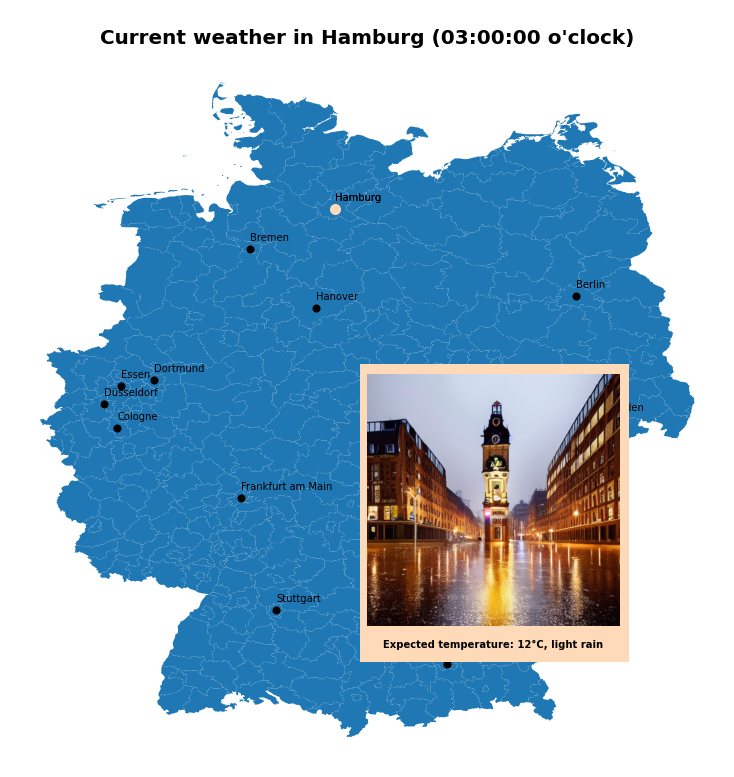

In [168]:
plot(prompt, coords, name)

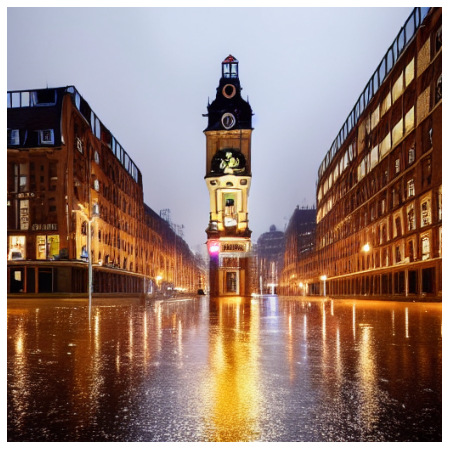

In [169]:
plt.figure(figsize=(8,8))
plt.imshow(Image.open("/content/output.png"))
plt.axis("off")
plt.show()

## Credits

We would like to thank [Keras](https://keras.io/) for the [Stable Diffusion](https://keras.io/guides/keras_cv/generate_images_with_stable_diffusion/) implementation and for the [Keras Community Prize](https://discuss.tensorflow.org/t/announcing-the-keras-community-prize-first-edition/13148/15).

By Cornelius Wolff & Maximilian Kalcher